<a href="https://colab.research.google.com/github/jpunit881/Jigsaw-Multilingual-Toxicity-Comment/blob/main/Jigsaw_Multilingual_Toxicity_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=4>As I get closer to the grandmaster tier, I want to take this opportunity to thank this amazing community which has taught me so much about data science and life in general. I also want to thank everyone who made this journey so beautiful and memorable!</font>

# Introduction

<center><img src="https://i.imgur.com/4WNesOq.png" width="400px"></center>

Welcome to the "Jigsaw Multilingual Toxic Comment Classification" competition! In this competition, contestants are challenged to build machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. This problem matters because one toxic comment is enough to sour an online discussion. By identifying and filtering toxic comments online, we can have a safer, more collaborative internet, leading to greater productivity and happiness.

In this kernel, I will explore the data with Plotly and Matplotlib. Then, I will explain and demonstrate how various deep learning models can be used to identify toxic comments with tensorflow.keras.

<font color="red" size=3>Please upvote this kernel if you like it. It motivates me to produce more quality content :)<br><br> This kernel may take a few extra seconds to load up, so please be patient!</font>

# Acknowledgements

1. [Jigsaw TPU: DistilBERT with Huggingface and Keras](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras) ~ by xhulu
2. [Jigsaw Multilingual: Quick EDA & TPU Modeling](https://www.kaggle.com/ipythonx/jigsaw-multilingual-quick-eda-tpu-modeling) ~ by Innat
3. [Stop the S@#! - Toxic Comments EDA](https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda) ~ by Jagan
4. [Google Translate API (googletrans)](https://pypi.org/project/googletrans/) ~ by ssut
5. [Polyglot](https://pypi.org/project/polyglot/) ~ by aboSamoor
6. [Dale–Chall readability formula](https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula) ~ by Wikipedia
7. [Automated readability index](https://en.wikipedia.org/wiki/Automated_readability_index) ~ by Wikipedia
8. [Flesch–Kincaid readability tests](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests) ~ by Wikipedia
9. [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) ~ by Rani Horev

# Contents

* [<font size=4>EDA</font>](#1)
    * [Preparing the ground](#1.1)
    * [Languages](#1.2)
    * [Comment words](#1.3)
    * [Sentiment and polarity](#1.4)
    * [Readability](#1.5)
    * [Targets](#1.6)
    
    
* [<font size=4>Modeling</font>](#2)
    * [Preparing the ground](#2.1)
    * [Vanilla neural network](#2.2)
    * [Convolutional neural network](#2.3)
    * [LSTM with Attention](#2.4)
    * [Capsule network](#2.5)
    * [DistilBERT](#2.6)
    
    
* [<font size=4>Takeaways</font>](#3)


* [<font size=4>Ending note</font>](#4)

# EDA <a id="1"></a>

First, I will visualize the comments in the training data before moving on to the modeling section.

## Preparing the ground <a id="1.1"></a>

### Install and import necessary packages

In [ ]:
!pip install -q pyicu
!pip install -q pycld2
!pip install -q polyglot
!pip install -q textstat
!pip install -q googletrans

In [ ]:
!pip install -q colorama

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import folium
import textstat
from scipy import stats
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
# from kaggle_datasets import KaggleDatasets
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,\
                                            CountVectorizer,\
                                            HashingVectorizer

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

import nltk
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from googletrans import Translator
from nltk import WordNetLemmatizer
from polyglot.detect import Detector
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)

### Load the training, validation, and testing datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
val_data = pd.read_csv("/content/drive/MyDrive/Jigsaw Multilingual-Toxicity-Comment/validation.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Jigsaw Multilingual-Toxicity-Comment/test.csv")
train_data = pd.read_csv("/content/drive/MyDrive/Jigsaw Multilingual-Toxicity-Comment/jigsaw-toxic-comment-train.csv")

In [ ]:
train_data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [ ]:
val_data.head()

id                                       comment_text lang  toxic
0   0  Este usuario ni siquiera llega al rango de    ...   es      0
1   1  Il testo di questa voce pare esser scopiazzato...   it      0
2   2  Vale. Sólo expongo mi pasado. Todo tiempo pasa...   es      1
3   3  Bu maddenin alt başlığı olarak  uluslararası i...   tr      0
4   4  Belçika nın şehirlerinin yanında ilçe ve belde...   tr      0

In [ ]:
test_data.head()

id                                            content lang
0   0  Doctor Who adlı viki başlığına 12. doctor olar...   tr
1   1   Вполне возможно, но я пока не вижу необходимо...   ru
2   2  Quindi tu sei uno di quelli   conservativi  , ...   it
3   3  Malesef gerçekleştirilmedi ancak şöyle bir şey...   tr
4   4  :Resim:Seldabagcan.jpg resminde kaynak sorunu ...   tr

### Wordcloud of all comments

In [ ]:
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

text = ' '.join([nonan(abstract) for abstract in train_data["comment_text"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')

In the wordcloud above, we can see the most common words in the comments. These words include "wikipedia", "page", and "article" among other words. More offensive words like "f**k" seem to occur less often, indicating that toxic, insulting comments are seen less frequently than non-toxic comments.

## Languages <a id="1.2"></a>

Now, I will analyze the distribution of languages in the dataset. To detect the language of comments in the dataset, I used the **Polyglot** package, which takes text as input and predicts the language of the text.

<center><img src="https://i.imgur.com/Hoa6IWg.png" width="450px"></center>

In [ ]:
def get_language(text):
    return Detector("".join(x for x in text if x.isprintable()), quiet=True).languages[0].name

train_data["lang"] = train_data["comment_text"].progress_apply(get_language)

100%|██████████| 223549/223549 [00:41<00:00, 5344.26it/s]


### English vs. Non-English

In [ ]:
lang_list = sorted(list(set(train_data["lang"])))
counts = [list(train_data["lang"]).count(cont) for cont in lang_list]
df = pd.DataFrame(np.transpose([lang_list, counts]))
df.columns = ["Language", "Count"]
df["Count"] = df["Count"].apply(int)

df_en = pd.DataFrame(np.transpose([["English", "Non-English"], [max(counts), sum(counts) - max(counts)]]))
df_en.columns = ["Language", "Count"]

fig = px.bar(df_en, x="Language", y="Count", title="Language of comments", color="Language", text="Count")
fig.update_layout(template="plotly_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[0].textfont.color = "black"
fig.data[0].textposition = "outside"
fig.data[1].textfont.color = "black"
fig.data[1].textposition = "outside"
fig

We can see that English comments dominate the training data, with a total of 220636 comments written in English and a mere 2913 comments written in languages other than English. There is a heavy imbalance in the language of comments in the training data.

### Bar chart of non-English languages

In [ ]:
fig = px.bar(df.query("Language != 'English' and Language != 'un'").query("Count >= 50"),
             y="Language", x="Count", title="Language of non-English comments", template="plotly_white", color="Language", text="Count", orientation="h")
fig.update_traces(marker=dict(line=dict(width=0.75,
                                        color='black')),  textposition="outside")
fig.update_layout(showlegend=False)
fig

We can see that German, Scots, and Danish are the most common non-English languages featuring in the dataset, with more than 100 comments in each language. Spanish, Persian, and Arabic are not far behind. We can thus conclude that Europe and the middle-east are the most represented regions in the dataset.

### Pie chart of non-English languages

In [ ]:
fig = go.Figure([go.Pie(labels=df.query("Language != 'English' and Language != 'un'").query("Count >= 50")["Language"],
           values=df.query("Language != 'English' and Language != 'un'").query("Count >= 50")["Count"])])
fig.update_layout(title_text="Pie chart of non-English languages", template="plotly_white")
fig.data[0].marker.colors = [px.colors.qualitative.Plotly[2:]]
fig.data[0].textfont.color = "black"
fig.data[0].textposition = "outside"
fig.show()

From the pie chart above, we can once again see that German, Danish, and Scots with more than 15% of the pie belonging to each of these three languages.

In [ ]:
def get_country(language):
    if language == "German":
        return "Germany"
    if language == "Scots":
        return "Scotland"
    if language == "Danish":
        return "Denmark"
    if language == "Arabic":
        return "Saudi Arabia"
    if language == "Spanish":
        return "Spain"
    if language == "Persian":
        return "Iran"
    if language == "Greek":
        return "Greece"
    if language == "Portuguese":
        return "Portugal"
    if language == "English":
        return "United Kingdom"
    if language == "Hindi":
        return "India"
    if language == "Albanian":
        return "Albania"
    if language == "Bosnian":
        return "Bosnia and Herzegovina"
    if language == "Croatian":
        return "Croatia"
    if language == "Dutch":
        return "Netherlands"
    if language == "Russian":
        return "Russia"
    if language == "Vietnamese":
        return "Vietnam"
    if language == "Somali":
        return "Somalia"
    if language == "Turkish":
        return "Turkey"
    if language == "Serbian":
        return "Serbia"
    if language == "Indonesian":
        return "Indonesia"
    if language == "Manx":
        return "Ireland"
    if language == "Scots":
        return "Scotland"
    if language == "Latin":
        return "Holy See (Vatican City State)"
    if language == "Afrikaans":
        return "South Africa"
    return "None"

df["country"] = df["Language"].progress_apply(get_country)

100%|██████████| 143/143 [00:00<00:00, 33286.28it/s]


### World plot of non-English languages

In [ ]:
fig = px.choropleth(df.query("Language != 'English' and Language != 'un' and country != 'None'").query("Count >= 5"), locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="Countries of non-English languages", color="Count",
                     template="plotly", color_continuous_scale="agsunset")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.2
fig.show()

From the word plot above, we can see that western Europe and the middle-east are the most represented regions in the dataset. Africa, Asia, and eastern Europe are relatively under-represented.

### Non-English European

In [ ]:
fig = px.choropleth(df.query("Language != 'English' and Language != 'un' and country != 'None'"), locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="Non-English European countries", color="Count",
                     template="plotly", color_continuous_scale="aggrnyl", scope="europe")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.2
fig.show()

We can see that German and English are the most common European languages to feature in the dataset, although Spanish and Greek are not far behind.

In [ ]:
fig = px.choropleth(df.query("Language != 'English' and Language != 'un' and country != 'None'"), locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="Asian countries", color="Count",
                     template="plotly", color_continuous_scale="spectral", scope="asia")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.2
fig.show()

This plot shows that middle-eastern languages such as Arabic and Persian are represented more than languages from the Indian subcontinent or south-east Asia, such as Hindi, Vietnamese, and Indonesian. There is not a single comment in Mandarin, Korean, or Japanese!

In [ ]:
fig = px.choropleth(df.query("Language != 'English' and Language != 'un' and country != 'None'").query("Count >= 5"), locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="African countries", color="Count",
                     template="plotly", color_continuous_scale="agsunset", scope="africa")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.2
fig.show()

We can see that Africa is not as well represented as the other continents in the dataset. The two most common African languages in the dataset are Afrikaans and Somali.

## Comment words <a id="1.3"></a>

Now, I will look at the number of words present in the comments.

### Distribution of comment words

In [ ]:
def new_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train_data["comment_words"] = train_data["comment_text"].apply(new_len)
nums = train_data.query("comment_words != 0 and comment_words < 200").sample(frac=0.1)["comment_words"]
fig = ff.create_distplot(hist_data=[nums],
                         group_labels=["All comments"],
                         colors=["coral"])

fig.update_layout(title_text="Comment words", xaxis_title="Comment words", template="simple_white", showlegend=False)
fig.show()

From the plot above, we can see that the distribution of comment words has a strong rightward (positive) skew with maximum probability denisty occuring at around 13 words. As the number of words increases beyond 13, the frequency reduces sharply.

### Average comment words vs. Language

In [ ]:
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["comment_words"]]))
df.columns = ["Language", "Average_comment_words"]
df["Average_comment_words"] = df["Average_comment_words"].apply(float)
df = df.query("Average_comment_words < 500")
fig = go.Figure(go.Bar(x=df["Language"], y=df["Average_comment_words"]))

fig.update_layout(xaxis_title="Language", yaxis_title="Average comment words", title_text="Average comment words vs. language", template="plotly_white")
fig.show()

I have plotted the average comment words in each language above. Certain languages tend to have more words on average than other languages. For example, comments written in Akan, Persian, and Sinhala have more than 300 words on average! This may be due to the small number of samples in these languages and presence of one or two outliers.

### Average comment length vs. Country

In [ ]:
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="Average comment length vs. Country", color="Average_comment_words",
                     template="plotly", color_continuous_scale="aggrnyl")
fig

In the world plot above, we can see that certain regions in the world tend to have a higher average comment length comment length than other countries. Persian, Arabic, and Hindi comments all have at least 100 words on average! Most long-comment languages seem to originate in Asia.

## Sentiment and polarity <a id="1.4"></a>

Sentiment and polarity are quantities that reflect the emotion and intention behind a sentence. Now, I will look at the sentiment of the comments using the NLTK (natural language toolkit) library.

<center><img src="https://i.imgur.com/LQF5WsC.png" width="800px"></center>

In [ ]:
def polarity(x):
    if type(x) == str:
        return SIA.polarity_scores(x)
    else:
        return 1000

SIA = SentimentIntensityAnalyzer()
train_data["polarity"] = train_data["comment_text"].progress_apply(polarity)

LookupError: ignored

### Negative sentiment

Negative sentiment refers to negative or pessimistic emotions. It is a score between 0 and 1; the greater the score, the more negative the abstract is.

In [ ]:
fig = go.Figure(go.Histogram(x=[pols["neg"] for pols in train_data["polarity"] if pols["neg"] != 0], marker=dict(
            color='seagreen')
    ))

fig.update_layout(xaxis_title="Negativity sentiment", title_text="Negativity sentiment", template="simple_white")
fig.show()

From the above plot, we can see that negative sentiment has a strong rightward (positive) skew, indicating that negativity is usually on the lower side. This suggests that most comments are not toxic or negative. In fact, the most common negativity value is around 0.04. Virtually no comments have a negativity greater than 0.8.

### Negativity vs. Country

In [ ]:
train_data["negativity"] = train_data["polarity"].apply(lambda x: x["neg"])
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["negativity"].tolist()]))
df.columns = ["Language", "Negativity"]
df["Negativity"] = df["Negativity"].apply(float)
df = df.query("Negativity != 0")
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                    projection="natural earth", locationmode="country names", title="Average negative sentiment vs. Country", color="Negativity",
                    template="plotly", color_continuous_scale="greens")
fig.show()

In the world plot, we can see that the language with highest average negativity is Afrikaans. Also, languages from western Europe and south-east Asia tend to have higher toxicity than Hindi and Russian.

### Negativity vs. Toxicity

In [ ]:
nums_1 = train_data.sample(frac=0.1).query("toxic == 1")["negativity"]
nums_2 = train_data.sample(frac=0.1).query("toxic == 0")["negativity"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Negativity vs. Toxicity", xaxis_title="Negativity", template="simple_white")
fig.show()

I have plotted the distribution of negativity for toxic and non-toxic comments above. We can clearly see that toxic comments have a significantly greater negative sentiment than toxic comments (on average). The probability density of negativity peaks at around 0 for non-toxic comments, while the negativity for toxic comments are minimum at this point. This suggests that a comment is very likely to be non-toxic if it has a negativity of 0.

### Positive sentiment

Positive sentiment refers to positive or optimistic emotions. It is a score between 0 and 1; the greater the score, the more positive the abstract is.

In [ ]:
fig = go.Figure(go.Histogram(x=[pols["pos"] for pols in train_data["polarity"] if pols["pos"] != 0], marker=dict(
            color='indianred')
    ))

fig.update_layout(xaxis_title="Positivity sentiment", title_text="Positivity sentiment", template="simple_white")
fig.show()

From the above plot, we can see that positive sentiment has a strong rightward (positive) skew, indicating that positivity is usually on the lower side. This suggests that most comments do not express positivity explicitly. In fact, the most common negativity value is around 0.08. Virtually no comments have a positivity greater than 0.8.

### Positivity vs. Country

In [ ]:
train_data["positivity"] = train_data["polarity"].apply(lambda x: x["pos"])
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["positivity"].tolist()]))
df.columns = ["Language", "Positivity"]
df["Positivity"] = df["Positivity"].apply(float)
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                    projection="natural earth", locationmode="country names", title="Average positive sentiment vs. Country", color="Positivity",
                    template="plotly", color_continuous_scale="reds")
fig.show()

In the world plot, we can see that the languages with the highest average positivity are English, Spanish, Portuguese, and Danish.

### Positivity vs. Toxicity

In [ ]:
nums_1 = train_data.sample(frac=0.1).query("toxic == 1")["positivity"]
nums_2 = train_data.sample(frac=0.1).query("toxic == 0")["positivity"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Positivity vs. Toxicity", xaxis_title="Positivity", template="simple_white")
fig.show()

I have plotted the distribution of positivity for toxic and non-toxic comments above. We can see that both the distributions are very similar, indicating that positivity is not an accurate indicator of toxicity in comments.

### Neutrality sentiment

Neutrality sentiment refers to the level of bias or opinion in the text. It is a score between 0 and 1; the greater the score, the more neutral/unbiased the abstract is.

In [ ]:
fig = go.Figure(go.Histogram(x=[pols["neu"] for pols in train_data["polarity"] if pols["neu"] != 1], marker=dict(
            color='dodgerblue')
    ))

fig.update_layout(xaxis_title="Neutrality sentiment", title_text="Neutrality sentiment", template="simple_white")
fig.show()

From the above plot, we can see that the neutrality sentiment distribution has a strong leftward (negative) skew, which is in constrast to the negativity and positivity sentiment distributions. This indicates that the comments tend to be very neutral and unbiased in general. This also suggests that most comments are not highly opinionated and polarizing, meaning that most comments are non-toxic.

### Neutrality vs. Country

In [ ]:
train_data["neutrality"] = train_data["polarity"].apply(lambda x: x["neu"])
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["neutrality"].tolist()]))
df.columns = ["Language", "Neutrality"]
df["Neutrality"] = df["Neutrality"].apply(float)
df = df.query("Neutrality != 1")
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                    projection="natural earth", locationmode="country names", title="Average neutral sentiment vs. Country", color="Neutrality",
                    template="plotly", color_continuous_scale="blues")
fig.show()

In the world plot, we can see that the languages with the highest neutrality are Persian, Hindi, and Russian. Few western European languages like German and English seem to have a lower average neutrality than most other languages.

### Neutrality vs. Toxicity

In [ ]:
nums_1 = train_data.sample(frac=0.1).query("toxic == 1")["neutrality"]
nums_2 = train_data.sample(frac=0.1).query("toxic == 0")["neutrality"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Neutrality vs. Toxicity", xaxis_title="Neutrality", template="simple_white")
fig.show()

We can see that non-toxic comments tend to have a higher neutrality value than toxic comments on average. The probability density of the non-toxic distribution experiences a sudden jump at 1, and the probability density of the toxic distribution is significantly lower at the same point. This suggests that a comment with neutrality close to 1 is more likely to be non-toxic than toxic.

### Compound sentiment

Compoundness sentiment refers to the total level of sentiment in the sentence. It is a score between -1 and 1; the greater the score, the more emotional the abstract is.

In [ ]:
fig = go.Figure(go.Histogram(x=[pols["compound"] for pols in train_data["polarity"] if pols["compound"] != 0], marker=dict(
            color='orchid')
    ))

fig.update_layout(xaxis_title="Compound sentiment", title_text="Compound sentiment", template="simple_white")
fig.show()

From the distribution above, we can see that compound sentiment is evenly distributed across the specturm (from -1 to 1) with very high variance and random peaks throughout the range.

### Average compound sentiment vs. Country

In [ ]:
train_data["compound"] = train_data["polarity"].apply(lambda x: x["compound"])
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["compound"].tolist()]))
df.columns = ["Language", "Compound"]
df["Compound"] = df["Compound"].apply(float)
df = df.query("Compound != 0")
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                    projection="natural earth", locationmode="country names", title="Average compound sentiment vs. Country", color="Compound",
                    template="plotly", color_continuous_scale="purples")
fig.show()

In the world plot above, we can see that western European countries, south-east Asia, and Turkey have a lower average compound sentiment than most other countries. India, Russia, and Iran are among the countries with the maximum compound sentiment.

### Compound sentiment vs. Toxicity

In [ ]:
nums_1 = train_data.sample(frac=0.1).query("toxic == 1")["compound"]
nums_2 = train_data.sample(frac=0.1).query("toxic == 0")["compound"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Compound vs. Toxicity", xaxis_title="Compound", template="simple_white")
fig.show()

We can see that compound sentiment tends to be higher for non-toxic comments as compared to toxic comments. The non-toxic distribution has a leftward (negative) skew, while the toxic distribution has a positive (rightward) skew. This indicates that non-toxic comments tend to have a higher compound sentiment than toxic comments on average.

## Readability <a id="1.5"></a>

Readability is an indication of how "easy" it is to read some text. There are several metrics that can be used to measure the readability of a piece of text, including Flesch reading ease, automated readability, and Dale-Chall readability. I will be using the textstat library to calculate the readability of comments in the dataset.

<center><img src="https://i.imgur.com/ySwAGNi.png" width="800px"></center>

In [ ]:
train_data["flesch_reading_ease"] = train_data["comment_text"].progress_apply(textstat.flesch_reading_ease)
train_data["automated_readability"] = train_data["comment_text"].progress_apply(textstat.automated_readability_index)
train_data["dale_chall_readability"] = train_data["comment_text"].progress_apply(textstat.dale_chall_readability_score)

### Flesch reading ease

The Flesch readability ease is an indicator designed to quantify how difficult a passage is to understand. The Flesch readability ease is calculated mathematically using the formula below:

<center><img src="https://i.imgur.com/nead3Kh.png" width="600px"></center>

From the above formula, we can see that comments with shorter words and fewer words per sentence are more "readable".

### Distribution of Flesch reading ease

In [ ]:
fig = go.Figure(go.Histogram(x=train_data.query("flesch_reading_ease > 0")["flesch_reading_ease"], marker=dict(
            color='darkorange')
    ))

fig.update_layout(xaxis_title="Flesch reading ease", title_text="Flesch reading ease", template="simple_white")
fig.show()

The Flesch reading ease distribution has a slight leftward (negative) skew, although the distribution is roughly normal. The most common values of the metric lie between 66 and 66.5.

### Flesch reading ease vs. Country

In [ ]:
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["flesch_reading_ease"].tolist()]))
df.columns = ["Language", "flesch_reading_ease"]
df["flesch_reading_ease"] = df["flesch_reading_ease"].apply(float)
df = df.query("flesch_reading_ease > 0")
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                    projection="natural earth", locationmode="country names", title="Average Flesch reading ease vs. Country", color="flesch_reading_ease",
                    template="plotly", color_continuous_scale="oranges")
fig.show()

In the world plot above, we can see that the Flesch readability ease is maximum in the Russian and Vietnamese languages. These languages have few words per sentence and few syllables per word, indicating that they are "easier" to read.

### Flesch reading ease vs. Toxicity

In [ ]:
nums_1 = train_data.sample(frac=0.1).query("toxic == 1")["flesch_reading_ease"]
nums_2 = train_data.sample(frac=0.1).query("toxic == 0")["flesch_reading_ease"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Flesch reading ease vs. Toxicity", xaxis_title="Flesch reading ease", template="simple_white")
fig.show()

I have plotted the distribution of Flesch reading ease for toxic and non-toxic comments above. We can see that both the distributions are very similar, indicating that Flesch reading ease is not an accurate indicator of toxicity in comments.

### Automated readability

The automated readability index (ARI) is a readability test, designed to gauge the understandability of a text. The automated readability index is calculated mathematically using the formula below:

<center><img src="https://i.imgur.com/7RukUx5.png" width="475px"></center>

From the above formula, we can see that comments with shorter words and fewer words per sentence are more "readable".

### Distribution of automated readability

In [ ]:
fig = go.Figure(go.Histogram(x=train_data.query("automated_readability < 100")["automated_readability"], marker=dict(
            color='mediumaquamarine')
    ))

fig.update_layout(xaxis_title="Automated readability", title_text="Automated readability", template="simple_white")
fig.show()

The automated readability distribution has a slight rightward (positive) skew, although the distribution has a roughly normal shape. The most common value of automated readability in the dataset is approximately 9. Very few comments have a readability ease greater than 60.

### Automated readability vs. Country

In [ ]:
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["automated_readability"].tolist()]))
df.columns = ["Language", "automated_readability"]
df["automated_readability"] = df["automated_readability"].apply(float)
df = df.query("automated_readability < 100")
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                    projection="natural earth", locationmode="country names", title="Automated readability vs. Country", color="automated_readability",
                    template="plotly", color_continuous_scale="GnBu")
fig.show()

In the world plot above, we can see that automated readability is maximum in Hindi, Arabic, and Somali comments. Whereas, Turkish, English, and south-east Asian comments seem to have relatively lower automated readability value than most countries.

### Automated readability vs. Toxicity

In [ ]:
nums_1 = train_data.sample(frac=0.1).query("toxic == 1")["automated_readability"]
nums_2 = train_data.sample(frac=0.1).query("toxic == 0")["automated_readability"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Automated readability vs. Toxicity", xaxis_title="Automated readability", template="simple_white")
fig.show()

I have plotted the distribution of automated readability for toxic and non-toxic comments above. We can see that both the distributions are very similar, indicating that automated readability is not an accurate indicator of toxicity in comments.

### Dale-Chall readability

The Dale–Chall readability formula is a readability test that provides a numeric gauge of the comprehension difficulty that readers come upon when reading a text. It uses a list of 3000 words that groups of fourth-grade American students could reliably understand, considering any word not on that list to be difficult. The Dale-Chall readability is calculated mathematically using the formula below:

<center><img src="https://i.imgur.com/KFG0QuU.png" width="525px"></center>

From the above formula, we can see that comments with fewer "difficult" words has a better readability and therefore a lower Dale-Chall readability score.

### Distribution of Dale-Chall readability

In [ ]:
fig = go.Figure(go.Histogram(x=train_data.query("dale_chall_readability < 20")["dale_chall_readability"], marker=dict(
            color='deeppink')
    ))

fig.update_layout(xaxis_title="Dale-Chall readability", title_text="Dale-Chall readability", template="simple_white")
fig.show()

The Dale-Chall readability distribution has a slight rightward (positive) skew, although the distribution has a roughly normal shape. There are also peaks to the left of the main distribution. The most common value of automated readability in the dataset is approximately 7. Very few comments have a readability ease greater than 20.

### Dale-Chall readability vs. Country

In [ ]:
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["dale_chall_readability"].tolist()]))
df.columns = ["Language", "dale_chall_readability"]
df["dale_chall_readability"] = df["dale_chall_readability"].apply(float)
df = df.query("dale_chall_readability < 20")
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                    projection="natural earth", locationmode="country names", title="Dale-Chall readability vs. Country", color="dale_chall_readability",
                    template="plotly", color_continuous_scale="PuRd")
fig.show()

The Dale-Chall readability score seems to be maximum in middle-eastern and south-east Asian languages. Russian and Arabic, on the other hand, have a lower Dale-Chall readability than most other languages in the dataset.

### Dale-Chall readability

In [ ]:
nums_1 = train_data.sample(frac=0.1).query("toxic == 1")["dale_chall_readability"]
nums_2 = train_data.sample(frac=0.1).query("toxic == 0")["dale_chall_readability"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Dale-Chall readability vs. Toxicity", xaxis_title="Dale-Chall readability", template="simple_white")
fig.show()

Dale-Chall readability seems to be higher (on average) for non-toxic comments, indicating that non-toxic comments use more "sophisticated" or "difficult" language. Toxic comments, on the other hand, are more blunt. We can see this from the fact that the non-toxic distribution peaks at a higher value than the toxic distribution.

## Targets <a id="1.6"></a>

Now, I will visualize the targets in the dataset.

### Wordclouds for different categories

### Non-toxic vs. Toxic

In [ ]:
clean_mask=np.array(Image.open("../input/imagesforkernal/safe-zone.png"))
clean_mask=clean_mask[:,:,1]

subset = train_data.query("toxic == 0")
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(7.5, 7.5))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

clean_mask=np.array(Image.open("../input/imagesforkernal/swords.png"))
clean_mask=clean_mask[:,:,1]

subset = train_data.query("toxic == 1")
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(7.5, 7.5))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

We can see from the above wordclouds, that toxic comments use more insluting or hateful words such as "f**k", while the non-toxic comments do not usually use such words.

### Obscene vs. Severe Toxic vs. Threat vs. Insult

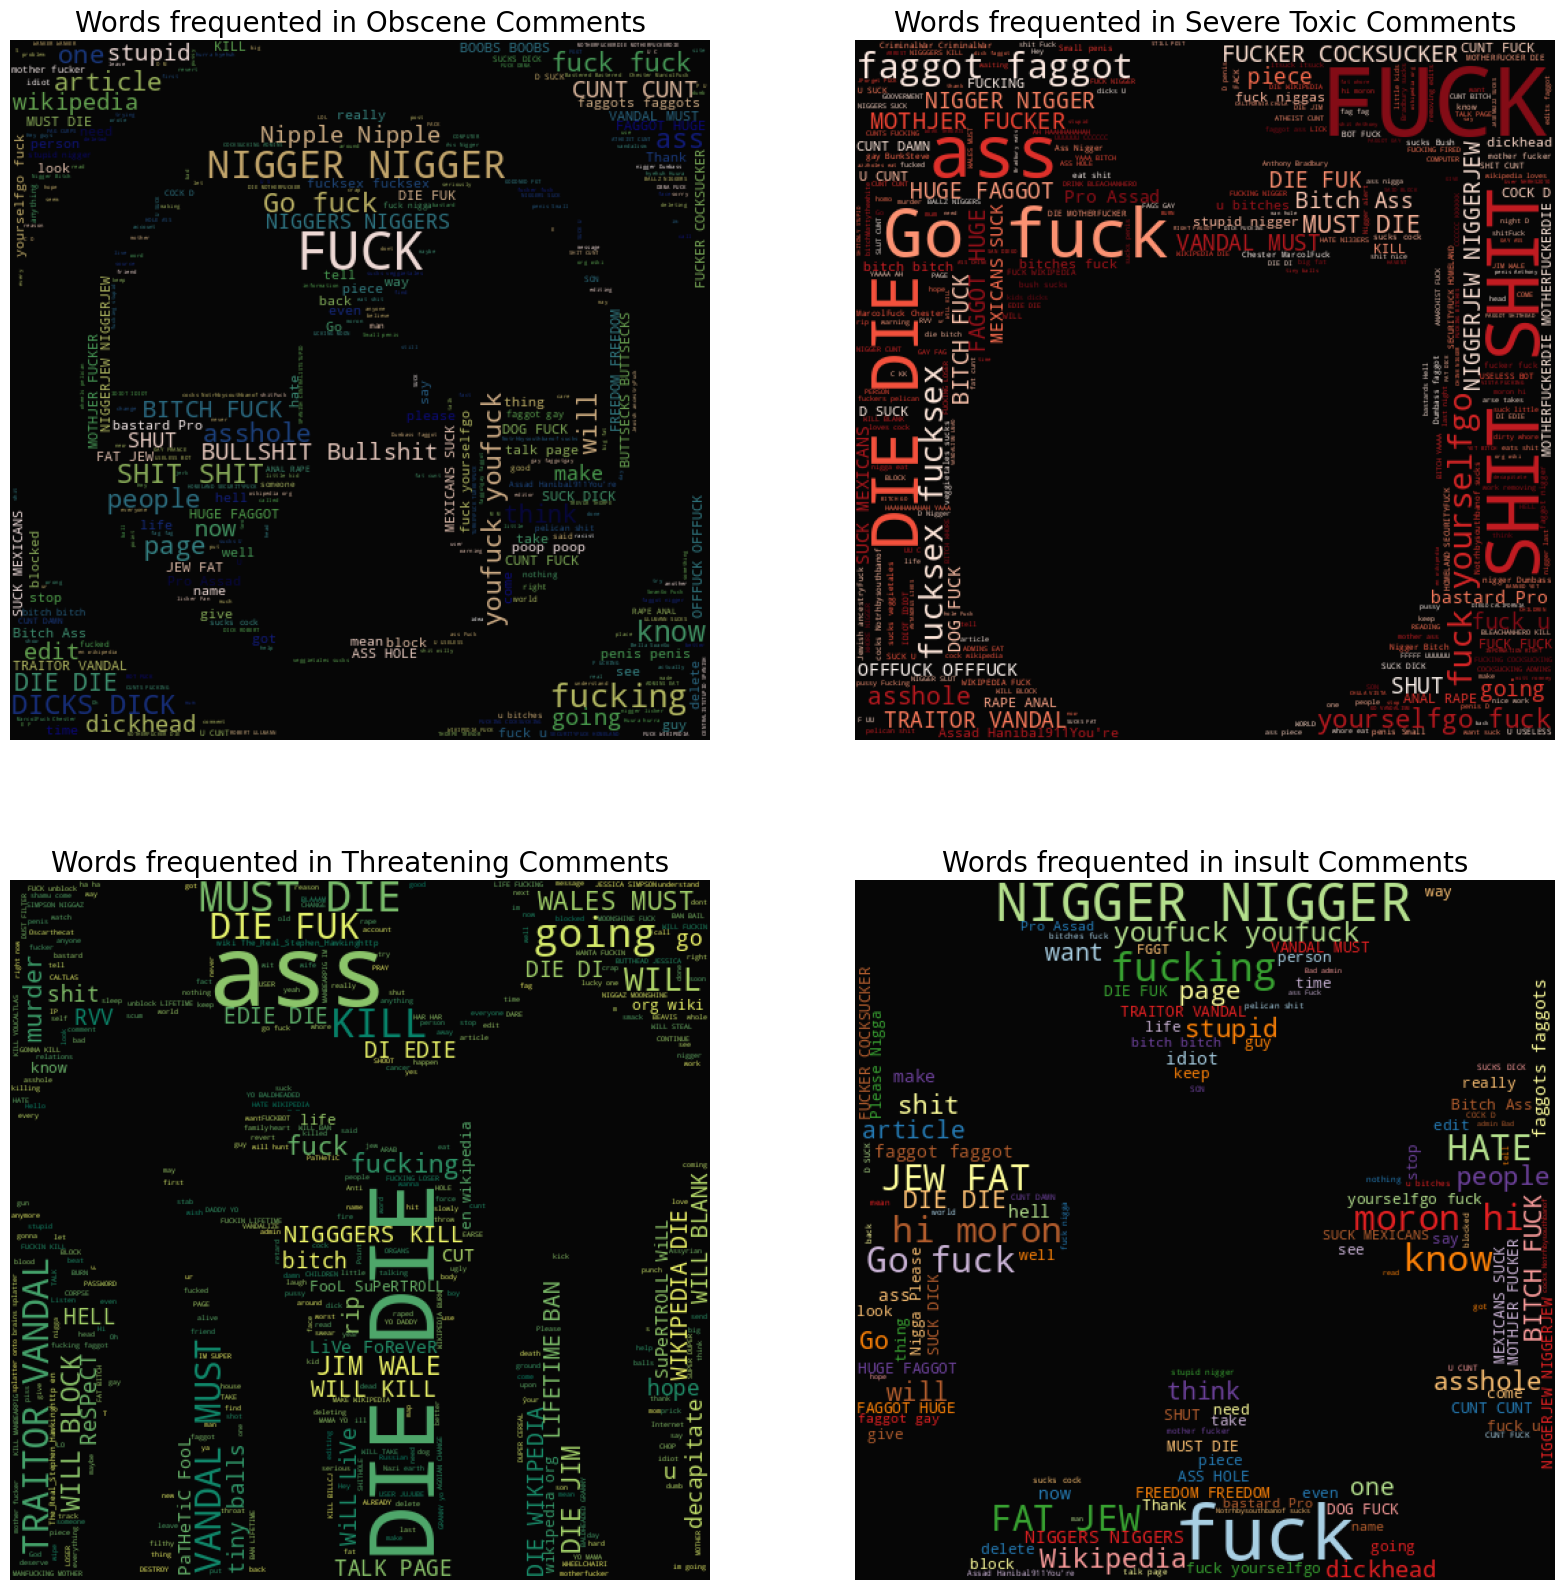

In [ ]:
toxic_mask=np.array(Image.open("../input/imagesforkernal/toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]
#wordcloud for clean comments
subset=train_data.query("obscene == 1")
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("../input/imagesforkernal/bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train_data[train_data.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("../input/imagesforkernal/anger.png"))
threat_mask=threat_mask[:,:,1]
subset=train_data[train_data.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("../input/imagesforkernal/swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train_data[train_data.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

In the above wordclouds, we can see that most of these categories use insulting/hateful language. But, the threat category seems to be slightly different from the remaining categories, as it uses words like "kill" and "die", indicating that most threats involve threats to kill someone.

### Pie chart of targets

In [ ]:
fig = go.Figure(data=[
    go.Pie(labels=train_data.columns[2:7],
           values=train_data.iloc[:, 2:7].sum().values, marker=dict(colors=px.colors.qualitative.Plotly))
])
fig.update_traces(textposition='outside', textfont=dict(color="black"))
fig.update_layout(title_text="Pie chart of labels")
fig.show()

From the pie chart above, we can see that the most common target is toxic, and the other targets, such as insult and threat are relatively uncommon.

### Bar chart of targets

In [ ]:
fig = go.Figure(data=[
    go.Bar(y=train_data.columns[2:7],
           x=train_data.iloc[:, 2:7].sum().values, marker=dict(color=px.colors.qualitative.Plotly))
])

fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.75
fig.update_traces(orientation="h")
fig.update_layout(title_text="Bar chart of labels", template="plotly_white")
fig.show()

From the bar chart above, we can once again see that toxic is the most common target, while threat is the rarest.

### Toxicity vs. Country

In [ ]:
df = pd.DataFrame(np.transpose([lang_list, train_data.groupby("lang").mean()["toxic"].tolist()]))
df.columns = ["Language", "toxicity"]
df["toxicity"] = df["toxicity"].apply(float)
df["country"] = df["Language"].apply(get_country)
df = df.query("country != 'None'")

fig = px.choropleth(df, locations="country", hover_name="country",
                    projection="natural earth", locationmode="country names", title="Average toxicity vs. Country", color="toxicity",
                    template="plotly", color_continuous_scale="tealrose")
fig.show()

From the above world plot, we can see that Irish and Afrikaans are the countries with maximum average toxicity, while most other countries have a similar average toxicity value.

# Modeling <a id="2"></a>

Now, I will show how different deep learning models can be used to classify toxic comments.

## Preparing the ground <a id="2.1"></a>

### Clean the text (remove usernames and links)

In [ ]:
val = val_data
train = train_data

def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

val["comment_text"] = clean(val["comment_text"])
test_data["content"] = clean(test_data["content"])
train["comment_text"] = clean(train["comment_text"])

### Define ROC-AUC evaluation metric

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

### Define function to tokenize (encode) comments

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []

    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

### Setup TPU configuration

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

EPOCHS = 2
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

### Load BERT tokenizer

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt',
                                        lowercase=True)

### Encode comments and get targets

In [ ]:
x_train = fast_encode(train.comment_text.astype(str),
                      fast_tokenizer, maxlen=512)
x_valid = fast_encode(val_data.comment_text.astype(str).values,
                      fast_tokenizer, maxlen=512)
x_test = fast_encode(test_data.content.astype(str).values,
                     fast_tokenizer, maxlen=512)

y_valid = val.toxic.values
y_train = train.toxic.values

### Define training, validation, and testing datasets

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

## Vanilla neural network <a id="2.2"></a>

Vanilla neural network refers to the classic neural network architecture.

<center><img src="https://i.imgur.com/ReZ9Ppl.png" width="500px"></center>

Vanilla neural networks consist of sequential layers that perform simple matrix multiplications and vector additions, until we reach the output layer. The propagation of values in a VNN can be represented with the following equation:

<center><img src="https://i.imgur.com/xbtn9ex.png" width="200px"></center>

where *W* is the weight matrix and *b* is the bias vector in layer *n*.

I will use the pretrained BERT embeddings as input, add the word vectors, and pass it through a VNN, as though it was tabular data and get the probability of the comment being toxic. The approach can be summarized using the flowchart below:

<center><img src="https://i.imgur.com/ORDcivv.png" width="315px"></center>

The same logic is implemented below using tf.keras.

### Define VNN model

In [ ]:
def build_vnn_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)

    conc = K.sum(embedding, axis=2)
    conc = Dense(128, activation='relu')(conc)
    conc = Dense(1, activation='sigmoid')(conc)

    model = Model(inputs=input_word_ids, outputs=conc)

    model.compile(Adam(lr=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### Build model and check summary

In [ ]:
with strategy.scope():
    transformer_layer = transformers.TFDistilBertModel.\
    from_pretrained('distilbert-base-multilingual-cased')
    model_vnn = build_vnn_model(transformer_layer, max_len=512)

model_vnn.summary()

### Visualize network architecture

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_vnn, dpi=70).create(prog='dot', format='svg'))

### Define ReduceLROnPlateau callback

In [ ]:
def callback():
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.3, patience=3,
                                    verbose=1, mode='auto',
                                    epsilon=0.0001, cooldown=1, min_lr=0.000001)
    cb.append(reduceLROnPlat)
    log = CSVLogger('log.csv')
    cb.append(log)

    RocAuc = RocAucEvaluation(validation_data=(x_valid, y_valid), interval=1)
    cb.append(RocAuc)

    return cb

### Train the model

In [ ]:
N_STEPS = x_train.shape[0] // BATCH_SIZE
calls = callback()

train_history = model_vnn.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks = calls,
    epochs=EPOCHS
)

### Visualize model predictions

Now, I will visualize the performance of the model on few validation samples.

In [ ]:
translator = Translator()

def visualize_model_preds(model, indices=[0, 17, 1, 24]):
    comments = val_data.comment_text.loc[indices].values.tolist()
    preds = model.predict(x_valid[indices].reshape(len(indices), -1))

    for idx, i in enumerate(indices):
        if y_valid[i] == 0:
            label = "Non-toxic"
            color = f'{Fore.GREEN}'
            symbol = '\u2714'
        else:
            label = "Toxic"
            color = f'{Fore.RED}'
            symbol = '\u2716'

        print('{}{} {}'.format(color, str(idx+1) + ". " + label, symbol))
        print(f'{Style.RESET_ALL}')
        print("ORIGINAL")
        print(comments[idx]); print("")
        print("TRANSLATED")
        print(translator.translate(comments[idx]).text)
        fig = go.Figure()
        if list.index(sorted(preds[:, 0]), preds[idx][0]) > 1:
            yl = [preds[idx][0], 1 - preds[idx][0]]
        else:
            yl = [1 - preds[idx][0], preds[idx][0]]
        fig.add_trace(go.Bar(x=['Non-Toxic', 'Toxic'], y=yl, marker=dict(color=["seagreen", "indianred"])))
        fig.update_traces(name=comments[idx])
        fig.update_layout(xaxis_title="Labels", yaxis_title="Probability", template="plotly_white", title_text="Predictions for validation comment #{}".format(idx+1))
        fig.show()

visualize_model_preds(model_vnn)

We can see that the model gets only two out of four answers correct. We need to find a better model to achieve a higher accuracy.

## Convolutional neural network <a id="2.3"></a>

Convolutional neural networks are a type of neural netork generally used for image recognition problems. But, the 1D version of CNNs can also be used for text-related problems (natural language processing). Convolution involves a process called convolution.

### Convolution

Convolution is a rather simple algorithm which involves a kernel (a 2D matrix) which moves over the entire matrix (word embeddings), calculating dot products with each window along the way. The GIF below demonstrates convolution in action.

<center><img src="https://i.imgur.com/wYUaqR3.gif" width="450px"></center>

The above process can be summarized with an equation, where *f* is the image and *h* is the kernel. The dimensions of *f* are *(m, n)* and the kernel is a square matrix with dimensions smaller than *f*:

<center><img src="https://i.imgur.com/9scTOGv.png" width="350px"></center>
<br>

In the above equation, the kernel *h* is moving across the length and breadth of the matrix. The dot product of *h* with a sub-matrix or window of matrix *f* is taken at each step, hence the double summation (rows and columns).

**In text classification, a 1D variant of convolution is used where the kernel moves in only one dimension.**

I will onace again use the pretrained BERT embeddings as input, pass the embeddings through convolutional layers, and get the probability of the comment being toxic. The approach can be summarized using the flowchart below:

<center><img src="https://i.imgur.com/7hsdV9T.png" width="315px"></center>

The same logic is implemented below using tf.keras.

### Define CNN model

In [ ]:
def build_cnn_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)

    embedding = SpatialDropout1D(0.3)(embedding)
    conv_1 = Conv1D(64, 2)(embedding)
    conv_2 = Conv1D(64, 3)(embedding)
    conv_3 = Conv1D(64, 4)(embedding)
    conv_4 = Conv1D(64, 5)(embedding)

    maxpool_1 = GlobalAveragePooling1D()(conv_1)
    maxpool_2 = GlobalAveragePooling1D()(conv_2)
    maxpool_3 = GlobalAveragePooling1D()(conv_3)
    maxpool_4 = GlobalAveragePooling1D()(conv_4)
    conc = concatenate([maxpool_1, maxpool_2, maxpool_3, maxpool_4], axis=1)

    conc = Dense(64, activation='relu')(conc)
    conc = Dense(1, activation='sigmoid')(conc)

    model = Model(inputs=input_word_ids, outputs=conc)

    model.compile(Adam(lr=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### Build model and check summary

In [ ]:
with strategy.scope():
    model_cnn = build_cnn_model(transformer_layer, max_len=512)

model_cnn.summary()

### Visualize network architecture

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_cnn, dpi=70).create(prog='dot', format='svg'))

### Train the model

In [ ]:
train_history = model_cnn.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks = calls,
    epochs=EPOCHS
)

### Visualize model predictions

Now, I will visualize the performance of the model on few validation samples.

In [ ]:
visualize_model_preds(model_cnn)

We can see the Conv1D model gives much more accurate predictions than the the VNN model. It predicts toxicity correctly for all four validation samples, because it is able to understand spatial relationships better.

## LSTM with Attention <a id="2.4"></a>


### LSTM

LSTMs are a type of neural network specifically made for NLP (text-related) tasks. In fact, LSTMs are a specific type of RNN. An RNN is a type of neural network that has a sense of direction (sequence). Classic neural networks look at all inputs at the same level, but RNNs look at inputs in a sequential order, which works well for text, as it is a sequential form of input.

But, RNNs have a problem called "vanishing gradients", which makes it difficult for it to understand long-term dependencies in text. Below is a depiction of the LSTM architecture which solves the problem of long-term dependencies:

<center><img src="https://i.imgur.com/gmijcvr.png" width="650px"></center>

### Attention

Attention is a mathematical mechanism that allows a neural network to select its main areas of focus ina sequence. Understanding which part of the comment to focus on (based on mathematics and probabilities) can be crucial in predicting whether it is toxic or not. The Attention mechanism can be combined with LSTMs to produce excellent NLP models.

The approach can be summarized with flowchart below:


<center><img src="https://i.imgur.com/SbFlht3.png" width="315px"></center>

### Define the Attention layer

In [ ]:
class AttentionWeightedAverage(Layer):

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

### Define the LSTM model

In [ ]:
def build_lstm_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)

    embedding = SpatialDropout1D(0.3)(embedding)
    lstm_1 = LSTM(128, return_sequences=True)(embedding)
    lstm_2 = LSTM(128, return_sequences=True)(lstm_1)

    attention = AttentionWeightedAverage()(lstm_2)
    conc = Dense(64, activation='relu')(attention)
    conc = Dense(1, activation='sigmoid')(conc)

    model = Model(inputs=input_word_ids, outputs=conc)

    model.compile(Adam(lr=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### Build the model and check summary

In [ ]:
with strategy.scope():
    model_lstm = build_lstm_model(transformer_layer, max_len=512)

model_lstm.summary()

### Visualize network architecture

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_lstm, dpi=70).create(prog='dot', format='svg'))

### Train the model

In [ ]:
train_history = model_lstm.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks = calls,
    epochs=EPOCHS
)

### Visualize model predictions

**Note: There are some errors which I am trying to fix here. The predictions cannot be visualized correctly.** But, I expect that LSTMs would perform well as they can understand text data well with attention.

In [ ]:
visualize_model_preds(model_lstm)

## Capsule network <a id="2.5"></a>

CNNs can extract features, but they cannot understand the spatial and proportional relationaships between objects in the image. Capsule networks solves this problem by understanding the spatial relationships between words (in text) by encoding additional information. A lot of the intuition behind how and why Capsule networks work is linked to image recognition, but it can also be used for text-based problems.

<center><img src="https://i.imgur.com/oWLRwwA.png" width="300px"></center>

For example, a CNN may be fooled into thinking the above image is a face as it cannot understand spatial relationships. But a Capsule network can understand these relationships and understand that this is not a face. The same logic applies for text as well. The approach can be summarized with the flowchart below:

<center><img src="https://i.imgur.com/FkyE6bA.png" width="315px"></center>

### Define the capsule layer

In [ ]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

class Capsule(Layer):

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 initializer='glorot_uniform',
                 activation=None,
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights

        self.activation = activations.get(activation)
        self.regularizer = regularizers.get(regularizer)
        self.initializer = initializers.get(initializer)
        self.constraint = constraints.get(constraint)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)

        self.build = True

    def call(self, inputs):
        if self.share_weights:
            u_hat_vectors = K.conv1d(inputs, self.W)
        else:
            u_hat_vectors = K.local_conv1d(inputs, self.W, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        u_hat_vectors = K.reshape(u_hat_vectors, (batch_size,
                                                  input_num_capsule,
                                                  self.num_capsule,
                                                  self.dim_capsule))

        u_hat_vectors = K.permute_dimensions(u_hat_vectors, (0, 2, 1, 3))
        routing_weights = K.zeros_like(u_hat_vectors[:, :, :, 0])

        for i in range(self.routings):
            capsule_weights = K.softmax(routing_weights, 1)
            outputs = K.batch_dot(capsule_weights, u_hat_vectors, [2, 2])
            if K.ndim(outputs) == 4:
                outputs = K.sum(outputs, axis=1)
            if i < self.routings - 1:
                outputs = K.l2_normalize(outputs, -1)
                routing_weights = K.batch_dot(outputs, u_hat_vectors, [2, 3])
                if K.ndim(routing_weights) == 4:
                    routing_weights = K.sum(routing_weights, axis=1)

        return self.activation(outputs)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

### Define the model

In [ ]:
def build_capsule_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)

    embedding = SpatialDropout1D(0.3)(embedding)
    capsule = Capsule(num_capsule=5, dim_capsule=5,
                      routings=4, activation=squash)(embedding)

    capsule = Flatten()(capsule)
    output = Dense(128, activation='relu')(capsule)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=input_word_ids, outputs=output)

    model.compile(Adam(lr=1.5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### Build the model and check summary

In [ ]:
with strategy.scope():
    model_capsule = build_capsule_model(transformer_layer, max_len=512)

model_capsule.summary()

### Train the model

In [ ]:
train_history = model_capsule.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks = calls,
    epochs=EPOCHS
)

### Visualize model architecture

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_capsule, dpi=70).create(prog='dot', format='svg'))

### Visualize model predictions

In [ ]:
visualize_model_preds(model_capsule)

We can see that the Capsule layer gets only 2 out of 4 predictions correctly. Maybe, this architecture is not well-suited to this text-related problem.

## DistilBERT <a id="2.6"></a>

### BERT

BERT (Bidirectional Encoder Representations from Transformers) was a paper published by researchers at Google AI Language, which caused a great stir in the NLP community as it became the SOTA on several NLP tasks.

BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training (such as LSTMs).

The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

### DistilBERT

DistilBERT is a lighter version of BERT (a very complex model) which uses fewer weights and achieves similar accuracies on several tasks with much lower training times. For this notebook, I will be using DistilBERT as it is easier to train in less time. The approach can be summarized with the flowchart below:

<center><img src="https://i.imgur.com/6AGu9a4.png" width="315px"></center>

### Define the model

In [ ]:
def build_distilbert_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    cls_token = Dense(500, activation="elu")(cls_token)
    cls_token = Dropout(0.1)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)

    model = Model(inputs=input_word_ids, outputs=out)

    model.compile(Adam(lr=1.5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### Build the model and check summary

In [ ]:
with strategy.scope():
    model_distilbert = build_distilbert_model(transformer_layer, max_len=512)

model_distilbert.summary()

### Train the model

In [ ]:
train_history = model_distilbert.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks = calls,
    epochs=EPOCHS
)

### Visualize model architecture

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_distilbert, dpi=70).create(prog='dot', format='svg'))

### Visualize model predictions

In [ ]:
visualize_model_preds(model_distilbert)

The model correctly classifies only 3 out of 4 validation samples. Maybe the model needs more training to give better results as it is a very complex model.

### Generate submission

In [ ]:
sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sub['toxic'] = model_distilbert.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

# Takeaways <a id="3"></a>

1. Sentiment scores such as negativity and neutrality might be great features for classifying toxic comments.
2. Several deep learning models can be used to classify toxic comments, such as Conv1D and LSTM.
3. Pretrained models like BERT often give better results as they have excellent representational capacity. Pretrained models can easily adapt to unseen tasks with minimal data.

# Ending note <a id="4"></a>

<font color="red" size=4>Please upvote this kernel if you like it. It motivates me to produce more quality content :)</font>